**簡単な説明**
- In[1] ライブラリのimport
- In[2] tableデータをdataframeとして読み込む
- In[3] dataframeの欠損値NaNを前後(※本番稼働だと後ろのデータは使えない)の値から線形補完
- In[4] dataframeの列に手数料と1時間後に決済したときのリターン(y_buyとy_sell)を追加
- In[5] hold-outでバリデーションを行い，訓練データで学習させたlightGBMを用いて全データ(訓練データ+検証データ+テストデータ)に対するリターンyの予測値を求める
- In[6] リターンyの予測値が0より大きい場合に注文を入れたとして，全データに対する累積リターンを図示する

**改良の余地がある部分**
- 特徴量の前処理
- 特徴量を増やす(そもそも取得するデータを増やす or 今あるデータを加工してかさ増しする)
- 執行方法を工夫する(今回は手数料が高い成行決済を用いている + 同じ方向の注文が連続しても毎回決済しているので手数料が多い)
- ハイパーパラメータ(lightGBM)を最適化する
-  hold-out以外のバリデーションを用いる
- 問題設定の変更(リターンyの回帰予測ではなく，リターンyが正か負のどちらを取るかの二値分類とするとか)
- 注文条件の変更(リターンyが0より大きい場合に注文ではなく，100より大きい場合に注文とすることで負けにくくするとか)

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [2]:
# 欠損値を指定してdata.csvを読み込む
df = pd.read_csv('../Record/60/data.csv', index_col=0, na_values='#####')
df = df.astype('float64')

df[383:388]

,open_time,liquidation_long,liquidation_short,oi,top_ls_account,top_ls_position,global_ls_account,buy_sell_ratio,closeprice,mark_closeprice,volume,number
383,1.642720e+09,135207.0,2660566.0,3.121500e+09,2.7509,1.1632,2.8715,0.8466,40661.69,40696.13839,35646.393,322673.0
384,1.642723e+09,151420.0,1069240.0,3.116468e+09,3.0519,1.1703,3.1929,0.8012,40884.57,40889.84234,35087.586,282475.0
385,1.642727e+09,150496.0,512080.0,3.114330e+09,NaN,NaN,NaN,0.7644,39750.69,39748.98912,37748.662,330487.0
386,1.642730e+09,388049.0,1045134.0,3.080920e+09,3.1982,1.1762,3.5106,0.8808,39818.48,39842.47365,47741.266,388739.0
387,1.642734e+09,1837192.0,12103525.0,3.076588e+09,3.4603,1.1628,3.8239,0.7817,38447.91,38443.17699,69754.853,563993.0


In [3]:
# 欠損値を前後の値から線形補完
df.interpolate(limit_direction='both', inplace=True)

In [4]:
# リターンyをdataframeに追加
# df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0.00036
df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0
df['y_buy'] = (-1) * df['closeprice'].diff(-1) - df['fee']
df['y_sell'] = df['closeprice'].diff(-1) - df['fee']

# 一番下の列はリターンyが定義できないので消去
df.dropna(inplace = True)

df[383:388]

,open_time,liquidation_long,liquidation_short,oi,top_ls_account,top_ls_position,global_ls_account,buy_sell_ratio,closeprice,mark_closeprice,volume,number,fee,y_buy,y_sell
383,1.642720e+09,135207.0,2660566.0,3.121500e+09,2.75090,1.16320,2.87150,0.8466,40661.69,40696.13839,35646.393,322673.0,0.0,222.88,-222.88
384,1.642723e+09,151420.0,1069240.0,3.116468e+09,3.05190,1.17030,3.19290,0.8012,40884.57,40889.84234,35087.586,282475.0,0.0,-1133.88,1133.88
385,1.642727e+09,150496.0,512080.0,3.114330e+09,3.12505,1.17325,3.35175,0.7644,39750.69,39748.98912,37748.662,330487.0,0.0,67.79,-67.79
386,1.642730e+09,388049.0,1045134.0,3.080920e+09,3.19820,1.17620,3.51060,0.8808,39818.48,39842.47365,47741.266,388739.0,0.0,-1370.57,1370.57
387,1.642734e+09,1837192.0,12103525.0,3.076588e+09,3.46030,1.16280,3.82390,0.7817,38447.91,38443.17699,69754.853,563993.0,0.0,372.08,-372.08


In [5]:
# 特徴量とモデルを定義
features_col = df.columns.values[1:-3]
features = df[features_col]
y_buy = df['y_buy']
y_sell = df['y_sell']
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# buy方向モデル

# 特徴量とラベルを[8:1:1]=[学習データ(tr):検証データ(va):テストデータ(te)]の割合で分割
tr_features, va_features, tr_y_buy, va_y_buy = train_test_split(features, y_buy, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_buy, te_y_buy = train_test_split(va_features, va_y_buy, test_size=0.5, random_state=1, shuffle=False)
# モデルの学習と全データ(訓練データ+検証データ+テストデータ)に対する予測
model.fit(tr_features, tr_y_buy)
pred_y_buy = pd.Series(data = model.predict(features), name= 'pred_y_buy')

# sell方向モデル

# 特徴量とラベルを(学習データ(tr):検証データ(va):テストデータ(te))=(8:1:1)の割合で分割
tr_features, va_features, tr_y_sell, va_y_sell = train_test_split(features, y_sell, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_sell, te_y_sell = train_test_split(va_features, va_y_sell, test_size=0.5, random_state=1, shuffle=False)
# モデルの学習と全データ(訓練データ+検証データ+テストデータ)に対する予測
model.fit(tr_features, tr_y_sell)
pred_y_sell = pd.Series(data = model.predict(features), name= 'pred_y_sell')

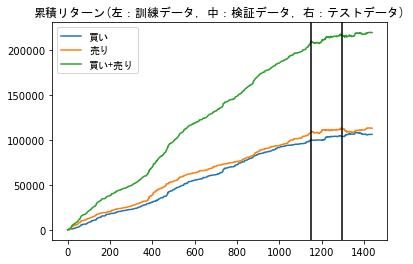

In [6]:
# 予測が正の場合に注文したとして累計リターンを図示する
df_result = pd.concat([y_buy, pred_y_buy, y_sell, pred_y_sell], axis=1)
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0)).cumsum().plot(label='買い')
(df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='売り')
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0) + df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.legend(prop={"family":"MS Gothic"})
plt.title('累積リターン(左：訓練データ，中：検証データ，右：テストデータ)', fontname="MS Gothic")
plt.axvline(x=len(features)*(8/10), color='k')
plt.axvline(x=len(features)*(9/10), color='k')
plt.show()

In [7]:
# 全データを使って本番用モデルを作る
# model.fit(df[features], df['y_buy'])
# pickle.dump(model, open('buy_model.pkl','wb'))

# model.fit(df[features], df['y_sell'])
# pickle.dump(model, open('sell_model.pkl','wb'))